# Team3_it
- 김대환, 김문수, 이영인

![Alt text](Data/subject.jpg)

### Result

![Alt text](Data/kaggle_result.jpg)

- 등수 : 291/1047(상위 27.8%)
- model : lightGBM

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from sklearn.preprocessing import LabelEncoder
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

In [2]:
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")

# 1. Structure of Data Sets

In [3]:
print(train.shape)
train.tail()

(647054, 7)


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
647049,39,191346,Sunday,3.239000e+10,1,PHARMACY OTC,1118.0
647050,39,191346,Sunday,7.874205e+09,1,FROZEN FOODS,1752.0
647051,39,191346,Sunday,4.072000e+03,1,PRODUCE,4170.0
647052,8,191347,Sunday,4.190008e+09,1,DAIRY,1512.0
647053,8,191347,Sunday,3.800060e+09,1,GROCERY DRY GOODS,3600.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 7 columns):
TripType                 647054 non-null int64
VisitNumber              647054 non-null int64
Weekday                  647054 non-null object
Upc                      642925 non-null float64
ScanCount                647054 non-null int64
DepartmentDescription    645693 non-null object
FinelineNumber           642925 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ MB


In [5]:
print(test.shape)
test.tail()

(653646, 6)


,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
653641,191348,Sunday,6.657211e+10,1,BATH AND SHOWER,1505.0
653642,191348,Sunday,8.818139e+10,1,BATH AND SHOWER,1099.0
653643,191348,Sunday,4.282557e+09,1,MENS WEAR,8220.0
653644,191348,Sunday,8.046919e+10,1,SWIMWEAR/OUTERWEAR,114.0
653645,191348,Sunday,7.871536e+09,1,MENS WEAR,4923.0


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653646 entries, 0 to 653645
Data columns (total 6 columns):
VisitNumber              653646 non-null int64
Weekday                  653646 non-null object
Upc                      649660 non-null float64
ScanCount                653646 non-null int64
DepartmentDescription    652318 non-null object
FinelineNumber           649660 non-null float64
dtypes: float64(2), int64(2), object(2)
memory usage: 29.9+ MB


# 2. Columns

|        Columns        | Data Type |                          Description                              | Unique value |
|:---------------------:|:---------:|:-----------------------------------------------------------------:|:------------:|
|        TripType       |   int64   | - 우리가 예측해야할것                                             |      38      |
|                       |           | - 손님들의 쇼핑 타입을 나타냄                                     |              |
|                       |           | - 각각의 숫자가 어떤 trip type인지에 대한 설명은 없음             |              |
|                       |           | - 999번은 기타                                                    |              |
|      VisitNumber      |   int64   | - 한 사람의 손님을 나타내는 id                                    |     95674    |
|                       |           | - 이에 해당하는 trip type도 하나                                  |              |
|        Weekday        |   object  | - 요일(월 ~ 일요일)                                               |       7      |
|          Upc          |  float64  | - 구매한 물건의 UPC(Universal Product Code)                       |     97715    |
|       ScanCount       |   int64   | - 해당물건을 몇개 구입했는지 나타냄                               |      39      |
|                       |           | - 음수는 환불했음을 의미함                                        |              |
|                       |           | - -12 ~71 까지 있음                                               |              |
|                       |           | - 평균은 1.1                                                      |              |
| DepartmentDescription |   object  | - 해당 물건의 상위레벨 분류                                       |      69      |
|                       |           | - 마트의 코너 개념                                                |              |
|     FinelineNumber    |  float64  | - Walmart에서 분류한 해당 물건의 좀 더 상세한 분류                |     5196     |

- VisitNumber는 손님 한 사람을 나타내는 id인데, 같은 VisitNumber인 row가 많음(이는, 한 사람이 여러 물품을 산 것을 나타냄) 
 -> 최종적으로는 VisitNumber로 groupby해야함

# 3. Feature Engineering

### 3-1. Missing Data
- Upc : 4192개
- DepartmentDescription : 1361개
- FinelineNumber : 4129개
- Upc, DepartmentDescription, FinelineNumber가 모두 null : 1361개

In [7]:
Upc_null = set(train["Upc"][train["Upc"].isnull()].index)
dd_null = set(train["DepartmentDescription"][train["DepartmentDescription"].isnull()].index)
fn_null = set(train["FinelineNumber"][train["FinelineNumber"].isnull()].index)
udf_null = list(Upc_null & dd_null & fn_null)

In [8]:
null_df = train.loc[udf_null, ["TripType"]]

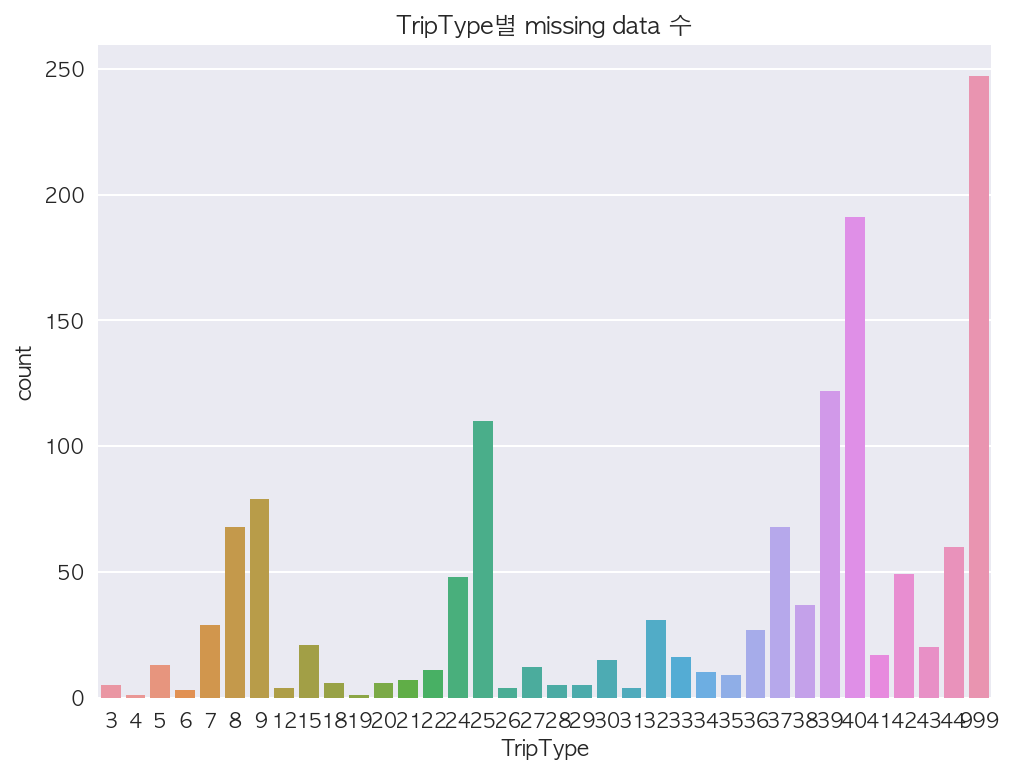

In [9]:
plt.figure(figsize=(8, 6))
sns.countplot(null_df['TripType'])
plt.title("TripType별 missing data 수")
plt.show()

### 3-2. Decoding UPCs

- About UPC(Universal Product Code) 

![Alt text](UPC_and_EAN.jpg)

- 주어진 UPC들의 길이
    - 1 ~ 12자리 까지 주어짐
    - 10자리와 11자리가 제일 많음
    - 1자리로된 UPC는 missing value로 처리함

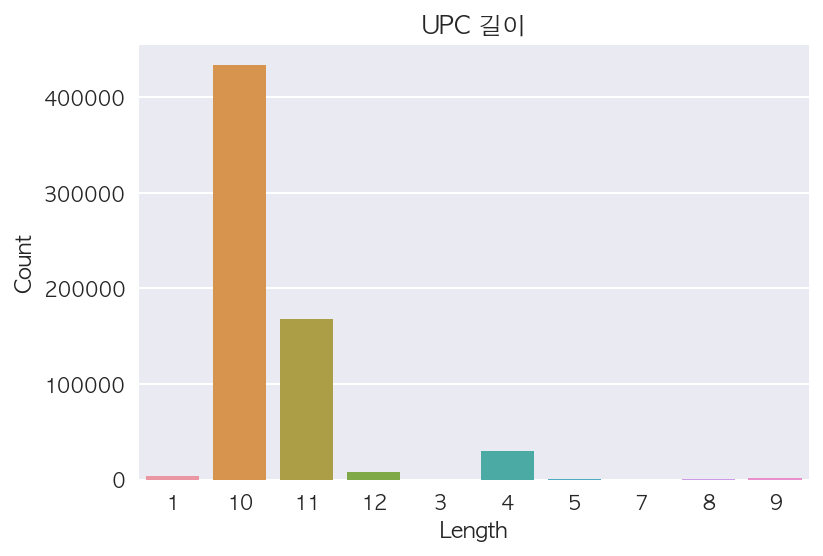

In [10]:
c = [4129, 7, 29745, 372, 1, 412, 2166, 433341, 168418, 8463]
length_of_UPC = pd.DataFrame({"Length":[1,3,4,5,7,8,9,10,11,12]})
length_of_UPC["Count"] = c
sns.barplot(length_of_UPC["Length"].astype(str), length_of_UPC["Count"])
plt.title("UPC 길이")
plt.show()

- Decoding UPCs

![Alt text](Decoding_UPCs_2.jpg)

In [11]:
# Check digit 추가하는 함수
def get_checkdigit(upc):
    
    odd_s = [int(i) for i in str(upc)[-1::-2]]
    even_s = [int(i) for i in str(upc)[-2::-2]]
    
    odd_sum = sum(list(map(lambda number : number * 3, odd_s)))
    even_sum = sum(list(map(lambda number : number, even_s)))
    check_sum = (odd_sum + even_sum) % 10
    

    if check_sum == 0:
        return check_sum
    else:
        return 10 - check_sum

In [12]:
# UPC길이를 12자리로 만드는 함수
def make_full_upc(upc):
    if upc == 0:
        return "missing"
    else:
        tmp_upc = str(upc) + str(get_checkdigit(upc))


        if len(tmp_upc) < 12:
            length = 12 - len(tmp_upc)
            zero = "0" * length
            standard_upc = zero + tmp_upc
            return standard_upc
        else:
            return tmp_upc 

In [13]:
# Company code와 Product code 추출
def classify_company_product(standard_upc):
    class_ = []
    
    if standard_upc == "missing":
        return standard_upc
    
    elif len(standard_upc) == 13:
        company = standard_upc[2:7]
        product = standard_upc[7:12]
        
        class_.append(company)
        class_.append(product)
        return class_
    
    # len = 12
    else: 
        if standard_upc[:6] == "000000":
            company = standard_upc[-6:-3]
            product = standard_upc[-3:-1]
            class_.append(company)
            class_.append(product)
            return class_
        else:
            company = standard_upc[1:6]
            product = standard_upc[6:11]

            class_.append(company)
            class_.append(product)
            return class_

In [14]:
# 추출한 Company code와 Product code로 각각의 column 만들기
def make_company_col(tmp):
    if tmp == "missing":
        return tmp
    else:
        return tmp[0]

def make_product_col(tmp):
    if tmp == "missing":
        return tmp
    else:
        return tmp[1]

# data['company_code'] = data['tmp'].apply(make_company_col)
# data['product_code'] = data['tmp'].apply(make_product_col)

### 3-3. DepartmentDescription
- train에만 있는 DepartmentDescription이 존재 -> 제외
- 더미 변수로 만듦

In [15]:
a = set(train["DepartmentDescription"]) - set(test["DepartmentDescription"])
print("train data에만 있는 DepartmentDescription : {}".format(a))

train data에만 있는 DepartmentDescription : {'HEALTH AND BEAUTY AIDS'}


### 3-4. TripType 14

In [16]:
df = train[['TripType', 'VisitNumber']].groupby(['VisitNumber']).mean()
df.reset_index(inplace=True)
df = df.groupby("TripType").size()
df = pd.DataFrame(df)
df.reset_index(inplace=True)
df.rename(columns={0:"Count"}, inplace=True)
df.sort_values(by=["Count"], ascending=False, axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)
df.tail()

,TripType,Count
33,19,375
34,4,346
35,12,269
36,23,139
37,14,4


In [17]:
df["Count"].describe()

count       38.000000
mean      2517.736842
std       3034.063074
min          4.000000
25%        585.750000
50%       1134.000000
75%       2981.750000
max      12161.000000
Name: Count, dtype: float64

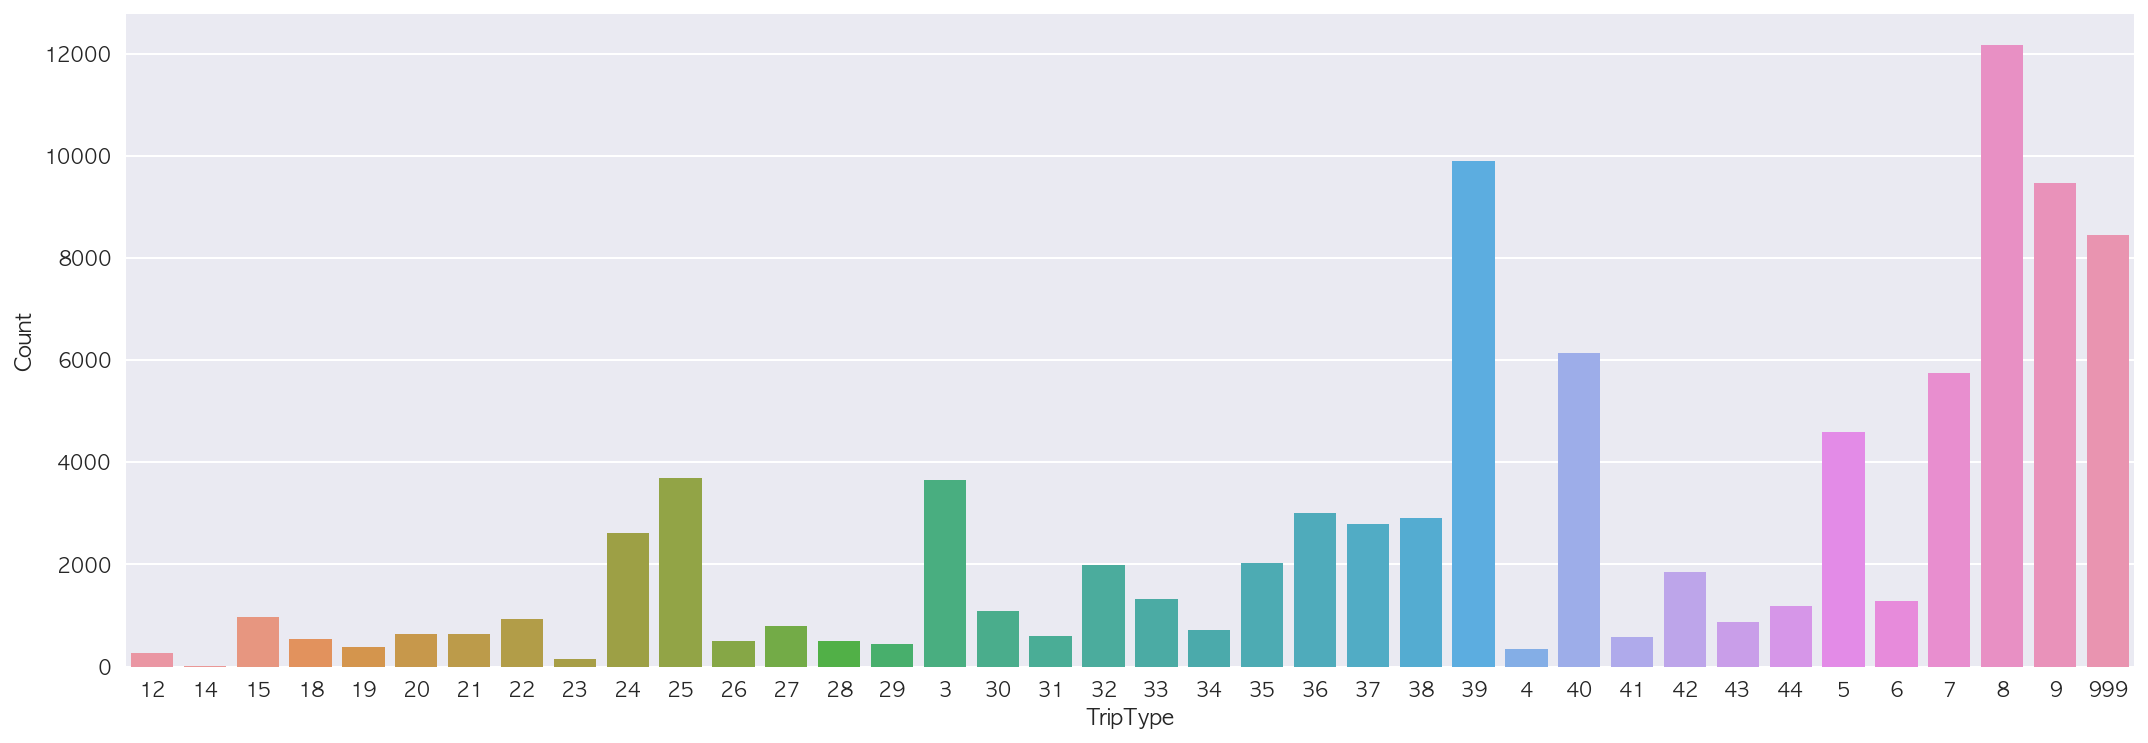

In [18]:
plt.figure(figsize=(18, 6))
sns.barplot(x=df["TripType"].astype(str), y=df["Count"])
plt.show()

- 다른 trip type보다 trip type 14가 상대적으로 수가 너무 적음

In [19]:
tt_14 = train[train["TripType"] == 14]
tt_14 = tt_14.groupby("VisitNumber")["DepartmentDescription"].apply(set)
tt_14 = pd.DataFrame(tt_14)
for i in list(tt_14.index):
    print(i, ":", list(tt_14.loc[i]))

2154 : [{'PETS AND SUPPLIES', 'IMPULSE MERCHANDISE'}]
12127 : [{'MEDIA AND GAMING', 'HOUSEHOLD PAPER GOODS', 'FABRICS AND CRAFTS'}]
25078 : [{'FINANCIAL SERVICES', 'PRODUCE', 'OFFICE SUPPLIES', 'FABRICS AND CRAFTS'}]
54761 : [{'CELEBRATION', 'FINANCIAL SERVICES', 'IMPULSE MERCHANDISE', 'FABRICS AND CRAFTS'}]


- 다른 id들은 공통적으로 FABRICS AND CRAFTS를 샀지만, 2154는 다른 id들과 동떨어진 물건들을 삼
- Visit number 2154는 trip type 14내의 outlier로 보고 제외함

또한 Type 14 Oversampling

### 3-5. FinelineNumber, DepartmentDescription, company_code, product_code

- 상품별 평균 판매량이 일정 수치 **이상**인 상품 제거 ( 모든 고객이 공통적으로 구매하는 상품)
- 남아 있는 상품 중, **TripType** 별로 1개 이상 구매한 **상품 리스트**체크
- **상품 리스트**에 있는 상품을 각 고객이 산 갯수 카운트

In [20]:
train_v1 = pd.read_csv("Data/train_v1.csv")
train_le = train_v1.copy()
le = LabelEncoder()
dd_le = le.fit_transform(list(train_le["DepartmentDescription"]))
train_le["DepartmentDescription"] = dd_le
fn_le = le.fit_transform(list(train_le["FinelineNumber"]))
train_le["FinelineNumber"] = fn_le
cc_le = le.fit_transform(list(train_le["company_code"]))
train_le["company_code"] = cc_le
pc_le = le.fit_transform(list(train_le["product_code"]))
train_le["product_code"] = pc_le

In [21]:
gb = train_le.groupby(by=["TripType", "DepartmentDescription"]).size()
gb = pd.DataFrame(gb)
gb.rename(columns={0:"Count"}, inplace=True)

In [22]:
tt_list = train["TripType"].unique()

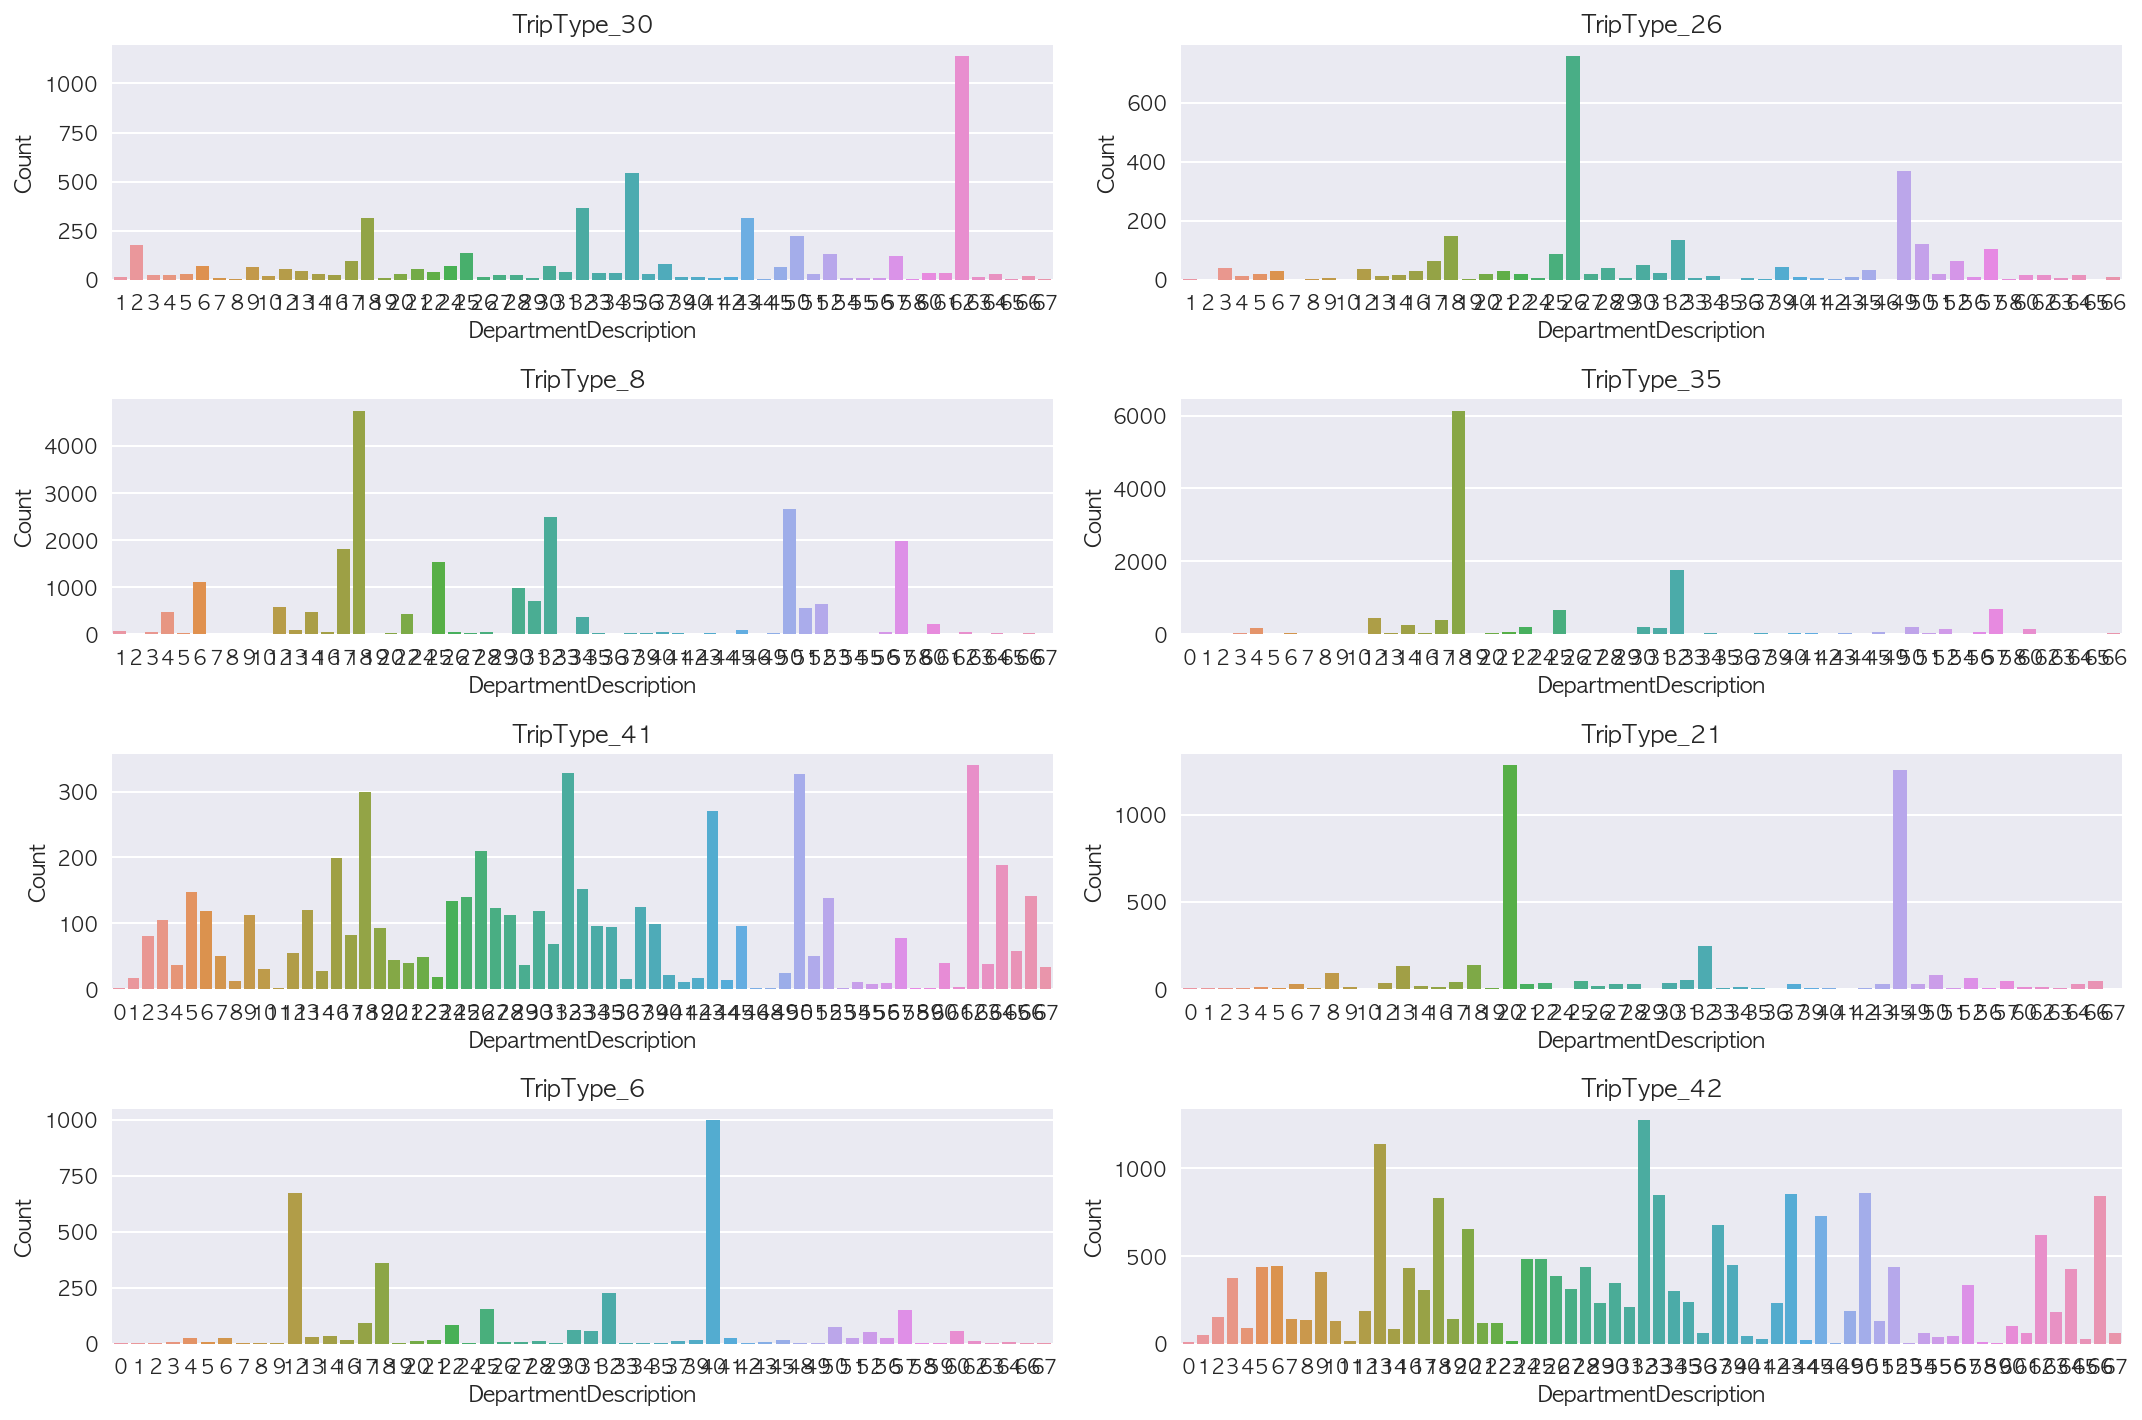

In [23]:
plt.figure(figsize=(15,10))
for i in range(1, 9):
    a = '42' + '{}'.format(i)
    plt.subplot(a)
    tt = tt_list[i]
    sns.barplot(x=gb.loc[tt].index,y=gb.loc[tt]["Count"], data=gb.loc[tt])
    plt.title("TripType_" + "{}".format(tt))
    
plt.tight_layout()
plt.show()

In [24]:
FLR = pd.read_csv('Data/fineline_rate_by_type.csv')
FLR.tail()

,VisitNumber,symtype_F_3,symtype_F_4,symtype_F_5,symtype_F_6,symtype_F_7,symtype_F_8,symtype_F_9,symtype_F_12,symtype_F_14,...,symtype_F_36,symtype_F_37,symtype_F_38,symtype_F_39,symtype_F_40,symtype_F_41,symtype_F_42,symtype_F_43,symtype_F_44,symtype_F_999
95669,191343,0.0,0.000000,0.023776,0.0,0.014255,0.028965,0.039534,0.0000,0.0,...,0.015147,0.017072,0.000000,0.003472,0.001901,0.120919,0.068411,0.104167,0.065125,0.018875
95670,191344,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
95671,191345,0.0,0.000000,0.000000,0.0,0.014255,0.000000,0.000000,0.0000,0.0,...,0.015147,0.000000,0.000000,0.006944,0.005704,0.060459,0.017103,0.052083,0.048844,0.018875
95672,191346,0.0,0.675676,0.000000,0.0,0.014255,0.000000,0.019767,0.3125,0.0,...,0.000000,0.017072,0.033693,0.020831,0.009506,0.060459,0.000000,0.052083,0.065125,0.000000
95673,191347,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.0,...,0.000000,0.008536,0.011231,0.003472,0.001901,0.060459,0.000000,0.052083,0.016281,0.000000


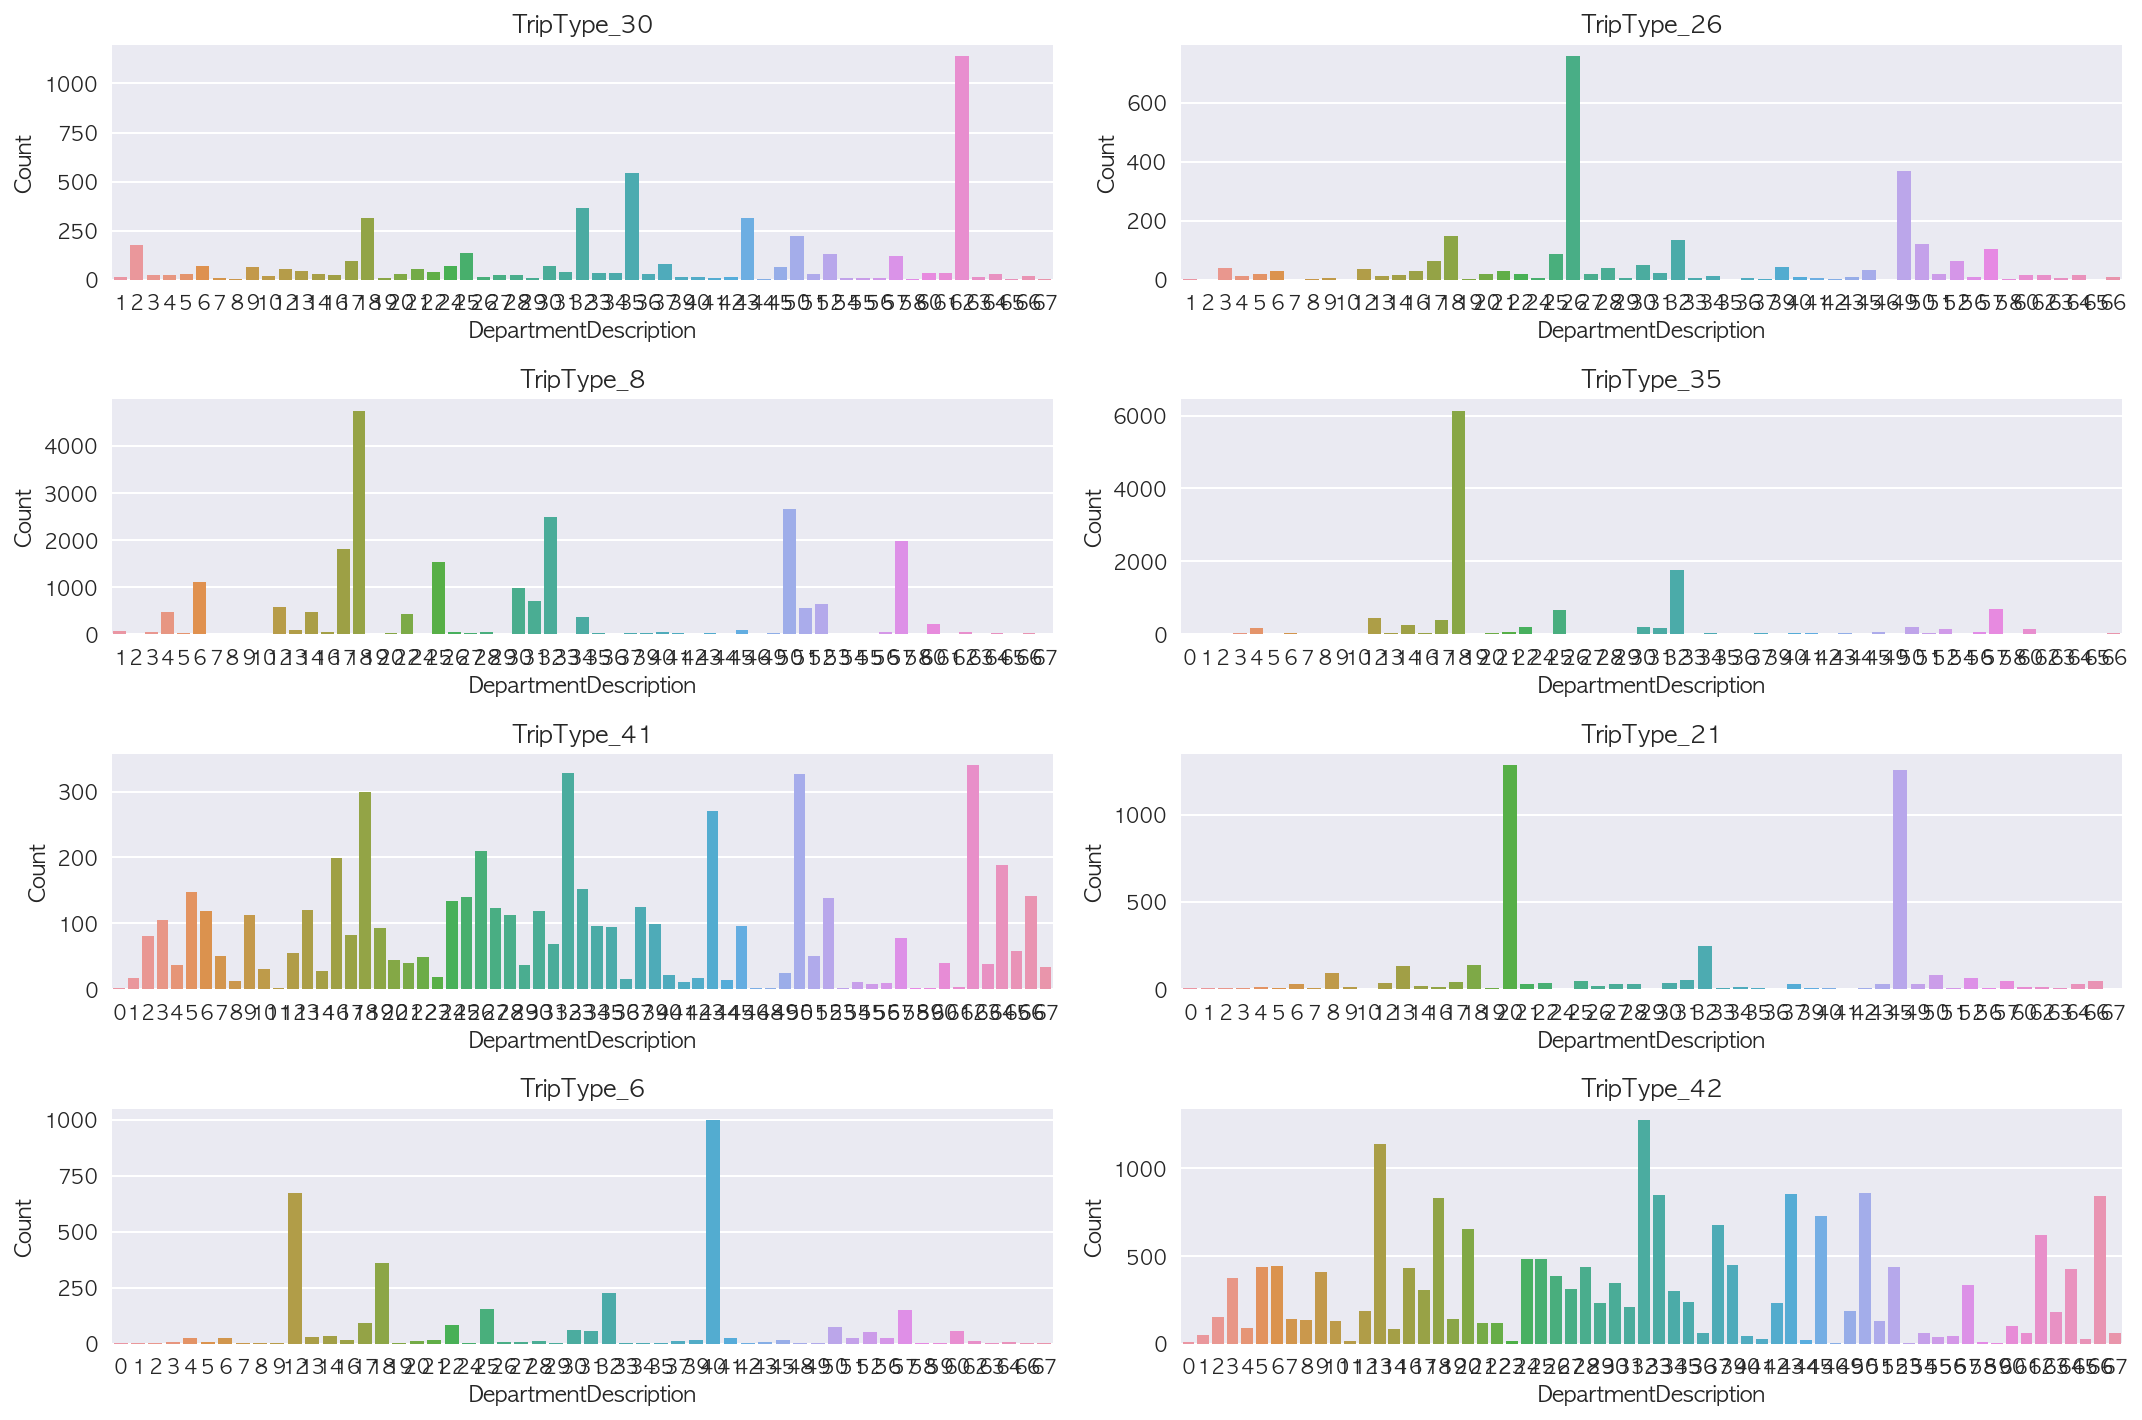

In [25]:
plt.figure(figsize=(15,10))
for i in range(1, 9):
    a = '42' + '{}'.format(i)
    plt.subplot(a)
    tt = tt_list[i]
    sns.barplot(x=gb.loc[tt].index,y=gb.loc[tt]["Count"], data=gb.loc[tt])
    plt.title("TripType_" + "{}".format(tt))
    
plt.tight_layout()
plt.show()

In [26]:
gb2 = train_le.groupby(by=["TripType", "FinelineNumber"]).size()
gb2 = pd.DataFrame(gb2)
gb2.rename(columns={0:"Count"}, inplace=True)

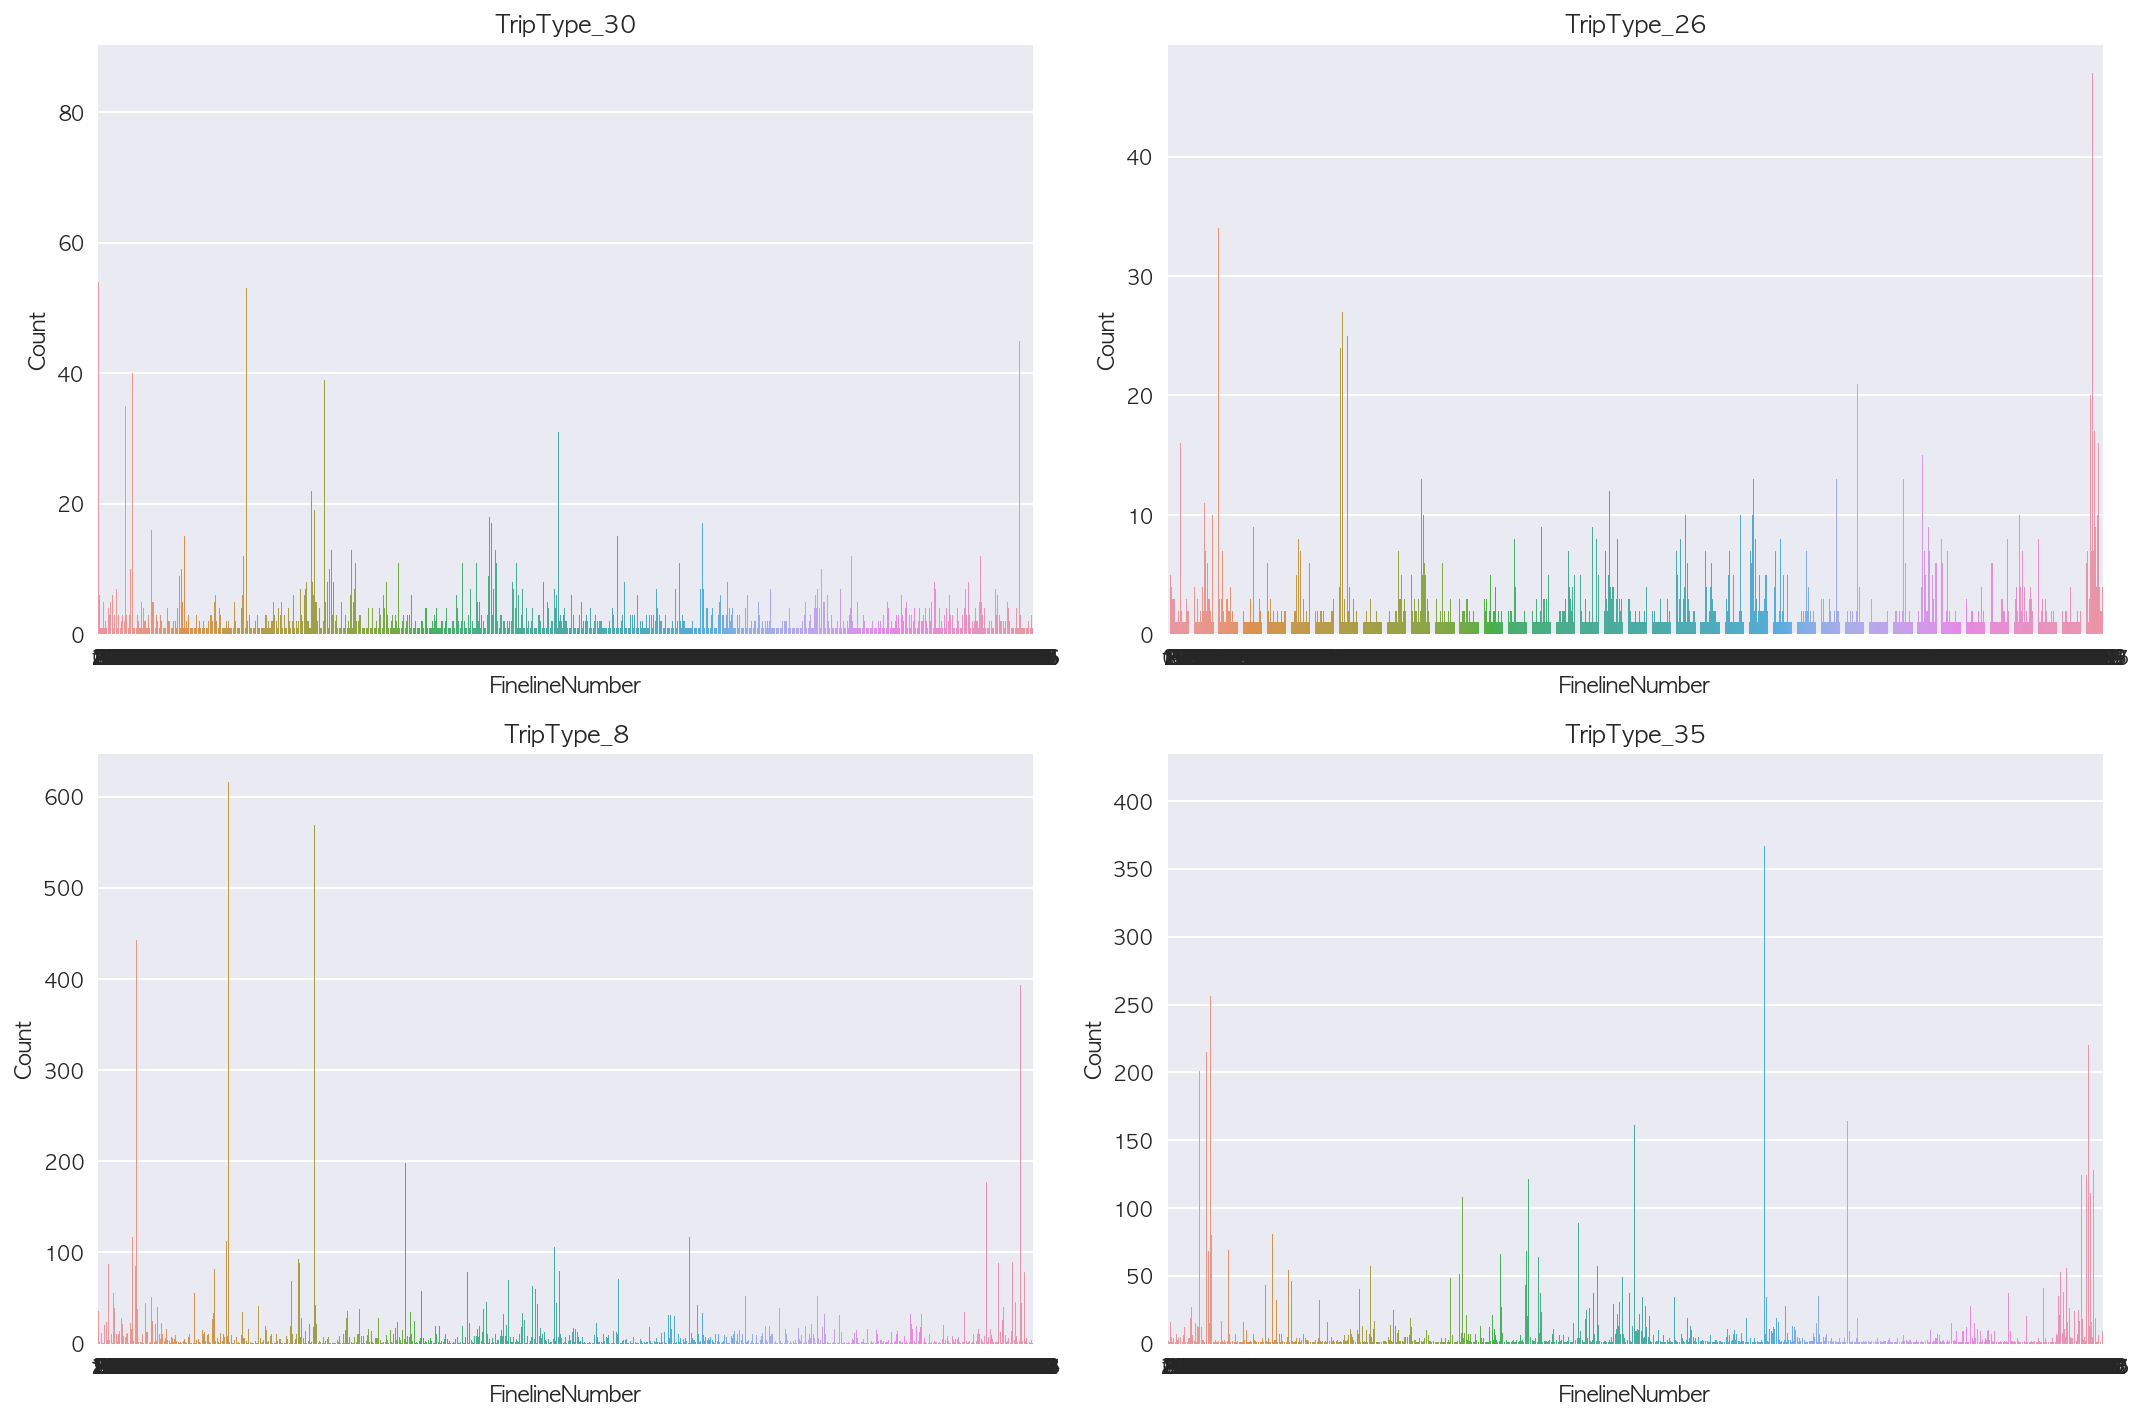

In [27]:
plt.figure(figsize=(15,10))
for i in range(1, 5):
    a = '22' + '{}'.format(i)
    plt.subplot(a)
    tt = tt_list[i]
    sns.barplot(x=gb2.loc[tt].index,y=gb2.loc[tt]["Count"], data=gb2.loc[tt])
    plt.title("TripType_" + "{}".format(tt))
    
plt.tight_layout()
plt.show()

In [28]:
gb3 = train_le.groupby(by=["TripType", "company_code"]).size()
gb3 = pd.DataFrame(gb3)
gb3.rename(columns={0:"Count"}, inplace=True)

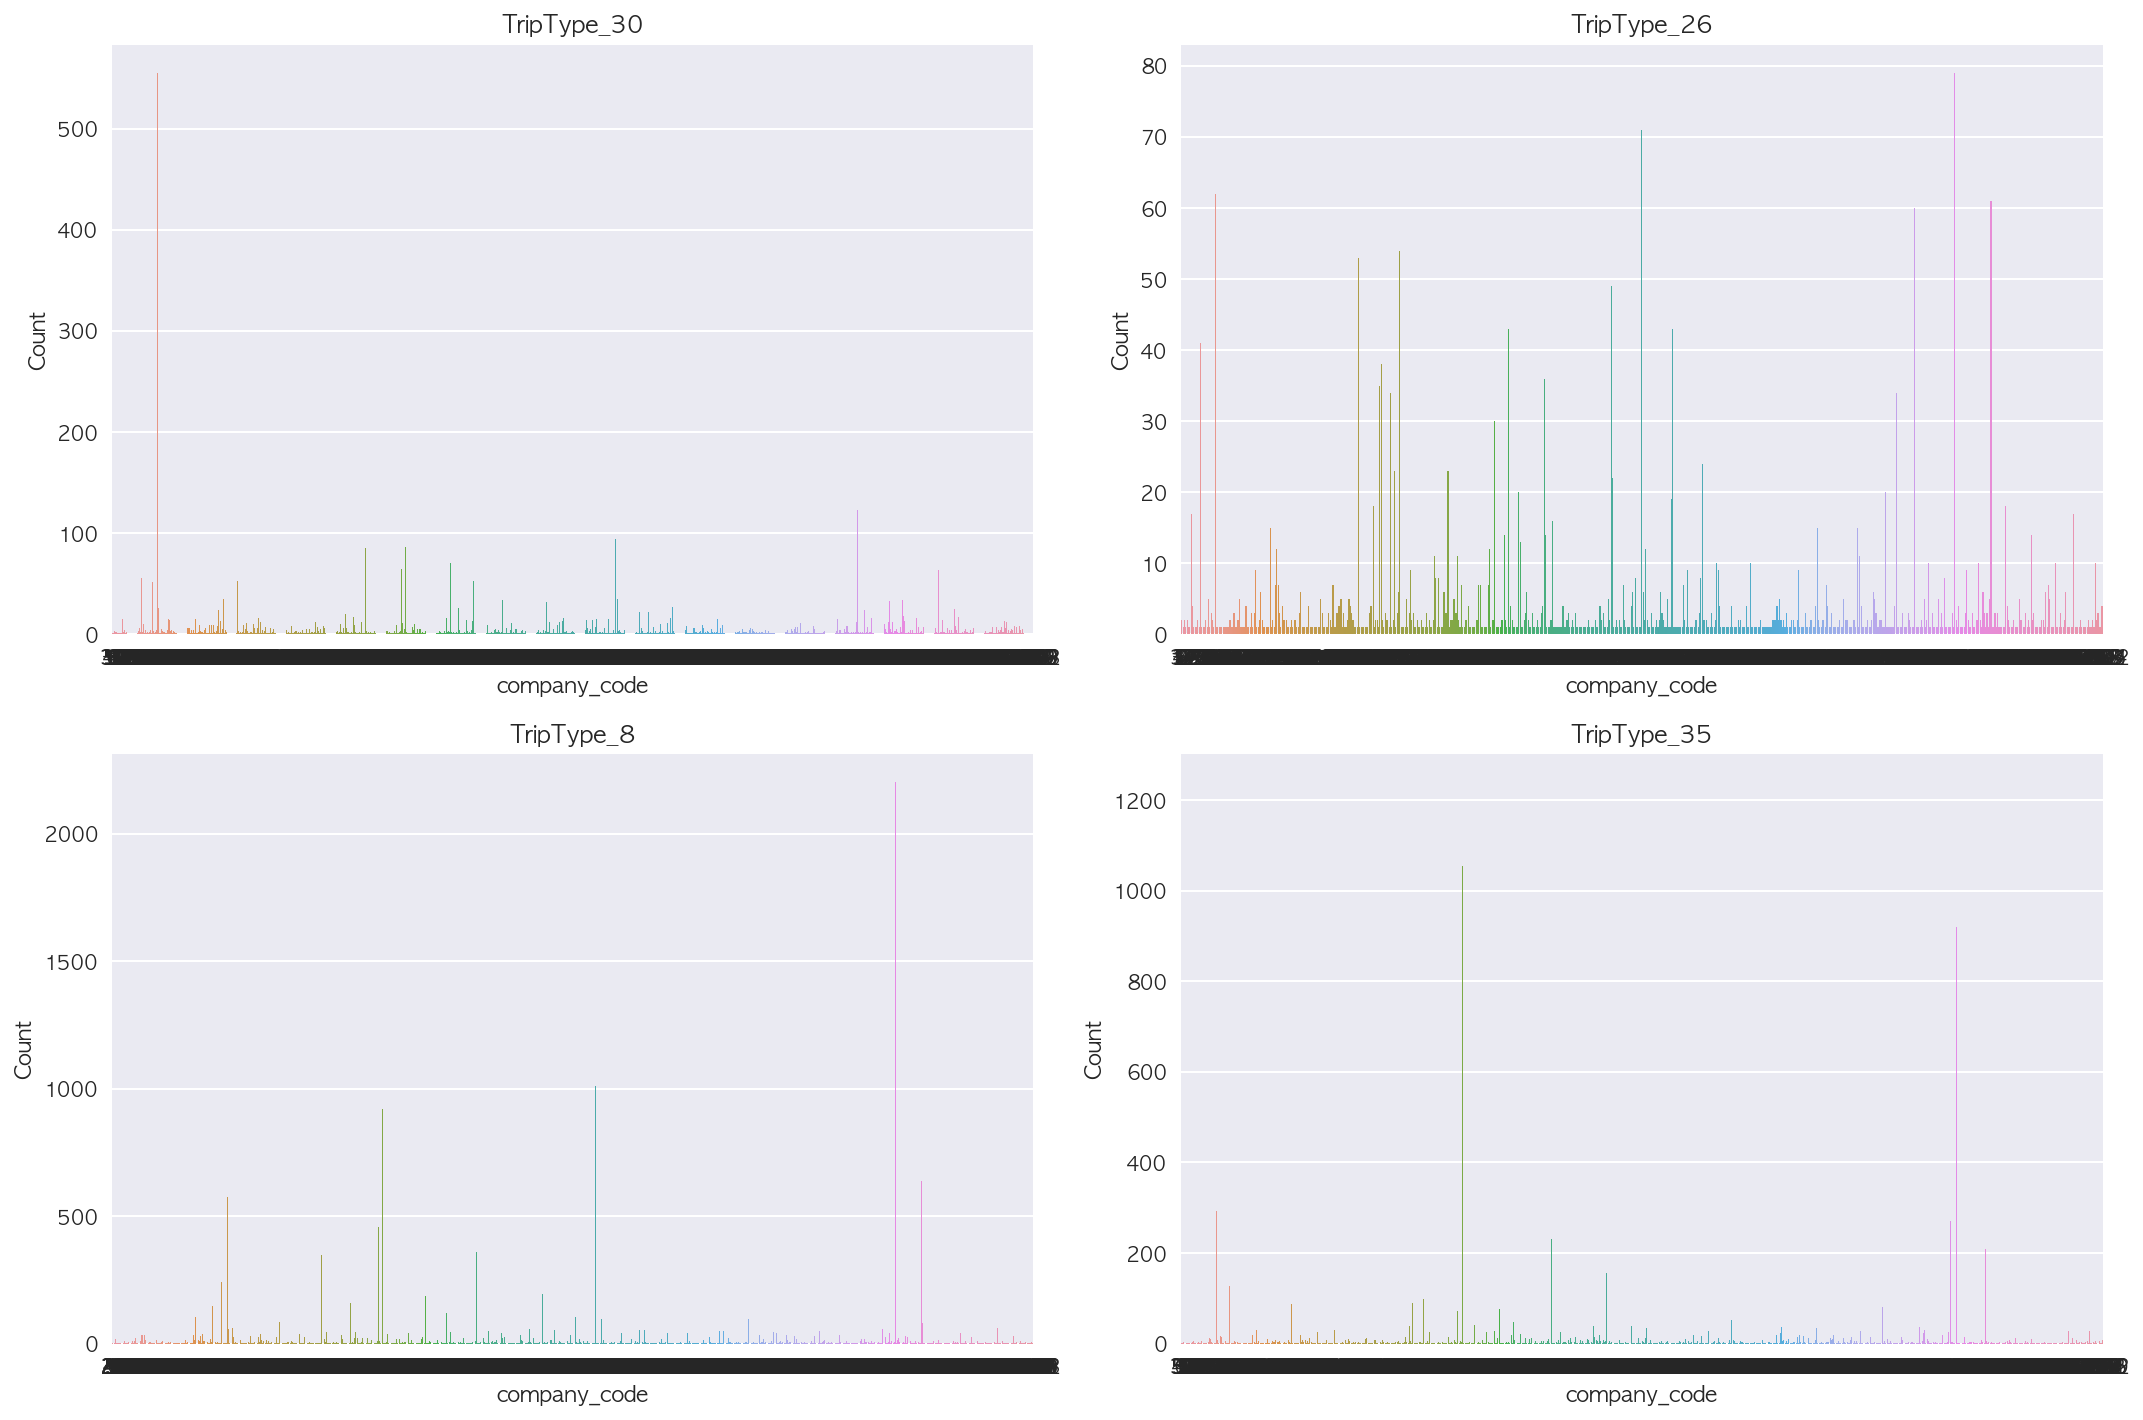

In [29]:
plt.figure(figsize=(15,10))
for i in range(1, 5):
    a = '22' + '{}'.format(i)
    plt.subplot(a)
    tt = tt_list[i]
    sns.barplot(x=gb3.loc[tt].index,y=gb3.loc[tt]["Count"], data=gb3.loc[tt])
    plt.title("TripType_" + "{}".format(tt))
    
plt.tight_layout()
plt.show()

### 3-6.

In [1]:
fn_rate = pd.read_csv("Data/fineline_rate_by_type.csv")

In [2]:
fn_rate.tail()

,VisitNumber,symtype_F_3,symtype_F_4,symtype_F_5,symtype_F_6,symtype_F_7,symtype_F_8,symtype_F_9,symtype_F_12,symtype_F_14,...,symtype_F_36,symtype_F_37,symtype_F_38,symtype_F_39,symtype_F_40,symtype_F_41,symtype_F_42,symtype_F_43,symtype_F_44,symtype_F_999
95669,191343,0.0,0.000000,0.023776,0.0,0.014255,0.028965,0.039534,0.0000,0.0,...,0.015147,0.017072,0.000000,0.003472,0.001901,0.120919,0.068411,0.104167,0.065125,0.018875
95670,191344,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
95671,191345,0.0,0.000000,0.000000,0.0,0.014255,0.000000,0.000000,0.0000,0.0,...,0.015147,0.000000,0.000000,0.006944,0.005704,0.060459,0.017103,0.052083,0.048844,0.018875
95672,191346,0.0,0.675676,0.000000,0.0,0.014255,0.000000,0.019767,0.3125,0.0,...,0.000000,0.017072,0.033693,0.020831,0.009506,0.060459,0.000000,0.052083,0.065125,0.000000
95673,191347,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.0,...,0.000000,0.008536,0.011231,0.003472,0.001901,0.060459,0.000000,0.052083,0.016281,0.000000


### 3-7. Purchase & Refund

In [3]:
train_e = pd.read_csv('Data/edited_train.csv')
train_e.tail()

,VisitNumber,refund,purchase,TripType,Weekday
95669,191343,0,9,25,7
95670,191344,0,5,22,7
95671,191345,0,17,39,7
95672,191346,0,17,39,7
95673,191347,0,2,8,7


In [4]:
ref_pur = train_e.groupby("TripType")["refund", "purchase"].mean()

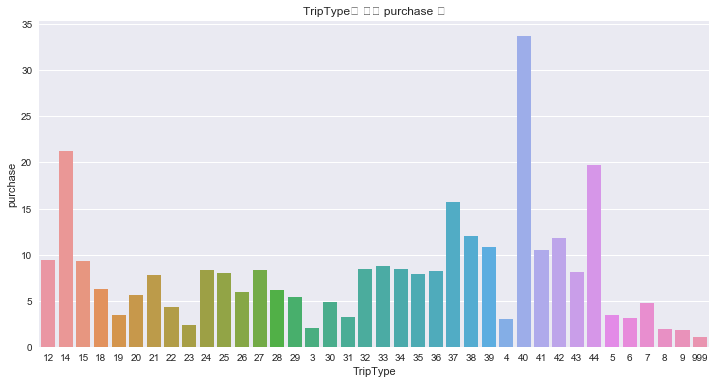

In [5]:
plt.figure(figsize=(12, 6))
sns.barplot(x=ref_pur.index.astype(str), y=ref_pur["purchase"])
plt.title("TripType별 평균 purchase 수")
plt.show()

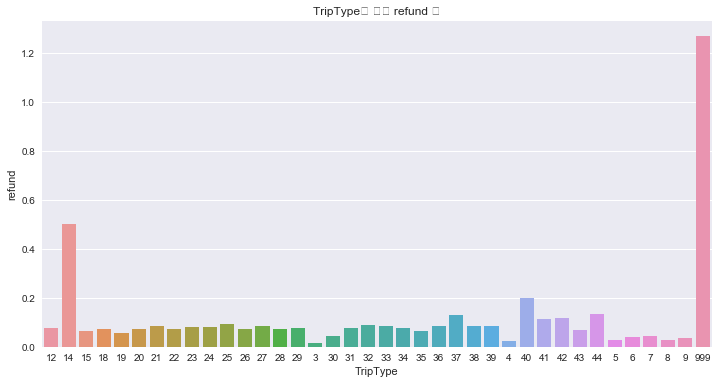

In [6]:
plt.figure(figsize=(12, 6))
sns.barplot(x=ref_pur.index.astype(str), y=ref_pur["refund"])
plt.title("TripType별 평균 refund 수")
plt.show()

-------------------

modeling

### read data

In [90]:
df = pd.read_csv('Data/edited_train.csv')
df_ = pd.read_csv('Data/edited_test.csv')

In [91]:
def convert_week(week):
    if week == 6 or week == 7:
        return 1
    else:
        return 0

In [92]:
df['Weekday'] = df['Weekday'].apply(convert_week)
df_['Weekday'] = df_['Weekday'].apply(convert_week)

In [93]:
feature1 = pd.read_csv('Data/purchase_rate_D.csv')
feature1_ = pd.read_csv('Data/t_purchase_rate_D.csv')

feature2 = pd.read_csv('Data/refund_D_ratio.csv')
feature2_ = pd.read_csv('Data/t_refund_D_ratio.csv')

feature4 = pd.read_csv('Data/unique_com.csv')
feature4_ = pd.read_csv('Data/t_unique_com.csv')

feature10 = pd.read_csv('Data/DD.csv')
feature10_ = pd.read_csv('Data/T_DD.csv')

feature11 = pd.read_csv('Data/fineline_rate_by_type.csv')
feature11_ = pd.read_csv('Data/t_fineline_rate_by_type.csv')

feature15 = pd.read_csv('Data/rate60%C_by_type.csv')
feature15_ = pd.read_csv('Data/t_rate60%C_by_type.csv')

for i in range(0,67+1):
   feature1.drop(columns=['D_%s' %(i)], inplace = True)
   feature1_.drop(columns=['D_%s' %(i)], inplace = True)
    
for i in range(0,67+1):
   feature2.drop(columns = ['Refund_D%s' %(i)], inplace = True)
   feature2_.drop(columns = ['Refund_D%s' %(i)], inplace = True)
    
del feature1['Unnamed: 0'], feature1_['Unnamed: 0']

In [94]:
# test

df = df.merge(feature1, how = 'left', on = 'VisitNumber')
df = df.merge(feature2, how = 'left', on = 'VisitNumber')
df = df.merge(feature4, how = 'left', on = 'VisitNumber')
df = df.merge(feature10, how = 'left', on = 'VisitNumber')
df = df.merge(feature11, how = 'left', on = 'VisitNumber')
df = df.merge(feature15, how = 'left', on = 'VisitNumber')

# test

df_ = df_.merge(feature1_, how = 'left', on = 'VisitNumber')
df_ = df_.merge(feature2_, how = 'left', on = 'VisitNumber')
df_ = df_.merge(feature4_, how = 'left', on = 'VisitNumber')
df_ = df_.merge(feature10_, how = 'left', on = 'VisitNumber')
df_ = df_.merge(feature11_, how = 'left', on = 'VisitNumber')
df_ = df_.merge(feature15_, how = 'left', on = 'VisitNumber')



### drop specific outlier

In [95]:
t_visit=df_['VisitNumber']

In [96]:
y = df['TripType']
X = df.drop(columns=['TripType'])

test = df_

### Oversampling - miniority data

In [97]:
#from imblearn.over_sampling import *

#X, y = SMOTE(random_state=0, k_neighbors=2, ratio='minority', n_jobs=-1).fit_sample(X, y)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(y)

from sklearn.model_selection import train_test_split

X_train, self_test_x = train_test_split(X, test_size = .2, random_state=0)
y_train, self_test_y = train_test_split(label, test_size = .2, random_state=0)


X_train, X_test = train_test_split(X_train, test_size = .25, random_state=0)
y_train, y_test = train_test_split(y_train, test_size = .25, random_state=0)

train_data = lgb.Dataset(X_train, label=y_train)

test_data = lgb.Dataset(X_test, label=y_test)

self_test_data = lgb.Dataset(self_test_x, label=self_test_y)

### parameter

In [98]:
param = {'objective': 'multiclass',  'num_class': 38, 
              'num_leaves':50, 'max_depth': 30,
              'boosting':'goss' 
                }
param['metric'] = 'multi_logloss'
param

{'boosting': 'goss',
 'max_depth': 30,
 'metric': 'multi_logloss',
 'num_class': 38,
 'num_leaves': 50,
 'objective': 'multiclass'}

### fitting

In [99]:
num_round = 120
bst = lgb.train(param, train_data, num_round, valid_sets=[test_data], early_stopping_rounds=30)

[1]	valid_0's multi_logloss: 2.61489
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's multi_logloss: 2.32497
[3]	valid_0's multi_logloss: 2.12225
[4]	valid_0's multi_logloss: 1.96466
[5]	valid_0's multi_logloss: 1.83699
[6]	valid_0's multi_logloss: 1.73023
[7]	valid_0's multi_logloss: 1.63851
[8]	valid_0's multi_logloss: 1.55862
[9]	valid_0's multi_logloss: 1.48922
[10]	valid_0's multi_logloss: 1.43034
[11]	valid_0's multi_logloss: 1.37733
[12]	valid_0's multi_logloss: 1.33029
[13]	valid_0's multi_logloss: 1.28725
[14]	valid_0's multi_logloss: 1.24889
[15]	valid_0's multi_logloss: 1.21405
[16]	valid_0's multi_logloss: 1.18246
[17]	valid_0's multi_logloss: 1.15347
[18]	valid_0's multi_logloss: 1.1267
[19]	valid_0's multi_logloss: 1.10233
[20]	valid_0's multi_logloss: 1.07968
[21]	valid_0's multi_logloss: 1.05951
[22]	valid_0's multi_logloss: 1.04136
[23]	valid_0's multi_logloss: 1.02486
[24]	valid_0's multi_logloss: 1.00861
[25]	valid_0's multi_logloss: 0.9938

In [106]:
lgb.cv(param, self_test_data, 50, nfold=5)

/Users/kimdh/.pyenv/versions/3.5.0/envs/mv_env350/lib/python3.5/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


{'multi_logloss-mean': [2.6557634196056381,
  2.3753109199331854,
  2.1774574489893452,
  2.0250854535955707,
  1.900752177594605,
  1.7969128037912108,
  1.7083259787986793,
  1.6313920901449528,
  1.5642999574237197,
  1.5101731900594624,
  1.4615324400408667,
  1.4180049668435475,
  1.3786139357931428,
  1.3423936497788038,
  1.3093610072953195,
  1.2791475583915026,
  1.2520747380537312,
  1.2270691064759958,
  1.204162034034026,
  1.1825905401947545,
  1.1634594835886642,
  1.1449277193046485,
  1.1283191377167652,
  1.1125142557229473,
  1.0981113282367592,
  1.0846628338074222,
  1.0718422100244223,
  1.060095697331767,
  1.0491477235098761,
  1.0393155266869882,
  1.0298848274882912,
  1.0206863614655666,
  1.0123842094363023,
  1.0047475525428351,
  0.99794403664319442,
  0.99134603742680372,
  0.98525997582631497,
  0.97923873809080086,
  0.97402687857926951,
  0.96960116441930411,
  0.96483713594339338,
  0.96033129264827277,
  0.95620741654028441,
  0.95235880951984642,
  0

### predict

In [102]:
ypred = bst.predict(test, num_iteration=bst.best_iteration)
ans = pd.DataFrame(ypred, columns=list(map(lambda x: 'TripType_{}'.format(x), le.classes_.astype(str))))
ans = pd.concat([t_visit, ans], axis=1)

ans.to_csv('Data/ans.csv', index=False)

### Feature Importance

Plot feature importances...


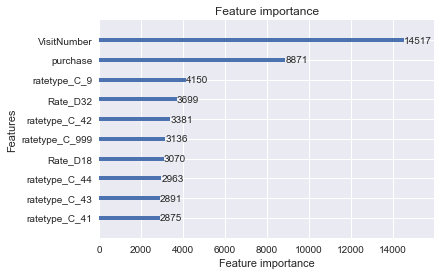

In [103]:
%matplotlib inline
print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=10)
plt.show()